In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt  # plotting
import numpy as np  # computating
import pandas as pd
import xarray as xr  # data handling

import sys
import os

import utils

**Data preparation for EOF analysis**

In [2]:
# *** 0. open data ***

# load dataset
path = os.getcwd()
data = xr.open_dataset(path+"/era5_monthly.nc")
# drop timesteps which contain NaN (later than Jan 2022)
data = data.dropna("time")

# *** 1. prepare data ***

# remove seasonal cycle
X_lonlat_global = data.msl.groupby("time.month") - data.msl.groupby("time.month").mean()
# remove time mean
X_lonlat_global = X_lonlat_global - X_lonlat_global.mean("time")
# crop
X_lonlat = X_lonlat_global.sel(longitude=slice(360 - 70, 360), latitude=slice(90, 20))
# create NxM matrix (N timesteps, M gridpoints)
X_gp = X_lonlat.stack(gp=("longitude", "latitude"))
N, M = X_gp.shape
print("Xp: N={} (timesteps), M={} (gridpoints)".format(N, M))
standardize = False
if standardize:
    X_gp = X_gp.groupby("time.month") / X_gp.groupby("time.month").std()
# area weighting
X_gp = X_gp * np.sqrt(np.cos(np.deg2rad(X_gp.latitude)))
# to numpy
Xp = X_gp.values

Xp: N=517 (timesteps), M=812 (gridpoints)


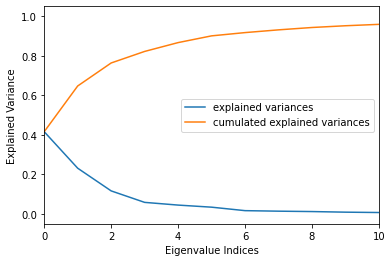

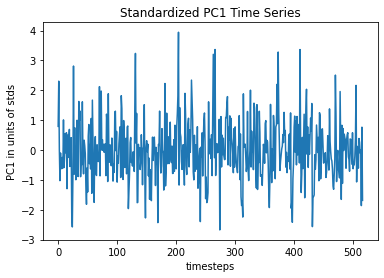

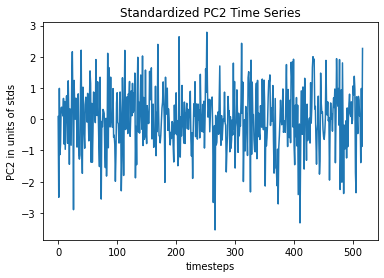

In [3]:
#compute covariance matrix C (if standardized c == corr matrix)

c = 1/N * Xp.T.dot(Xp)

#compute and sort (from largest to smallest) the eigenvectors and -values v,w

w, v = np.linalg.eig(c)
idx_sort = np.argsort(w)[::-1]
w, v = w[idx_sort], v[:, idx_sort]

#compute and plot explained variance for each eigenvalue

exp_var = np.zeros(w.shape)
for i in range(len(w)):
    exp_var[i] = (w.real[i]/w.real.sum())
    
plt.plot(range(len(w)), exp_var, label = 'explained variances')
plt.plot(range(len(w)), np.cumsum(exp_var), label = 'cumulated explained variances')
plt.xlim((0,10))
plt.legend()
plt.xlabel('Eigenvalue Indices')
plt.ylabel('Explained Variance')
plt.show()

#compute first and second standardized principal components

PC1 = Xp.dot(v.real[0])
PC1_std = (PC1 - PC1.mean(axis = 0)) / PC1.std(axis = 0)
PC2 = Xp.dot(v.real[1])
PC2_std = (PC2 - PC2.mean(axis = 0)) / PC2.std(axis = 0)

plt.plot(PC1_std)
plt.title('Standardized PC1 Time Series')
plt.xlabel('timesteps')
plt.ylabel('PC1 in units of stds')
plt.show()

plt.plot(PC2_std)
plt.title('Standardized PC2 Time Series')
plt.xlabel('timesteps')
plt.ylabel('PC2 in units of stds')
plt.show()

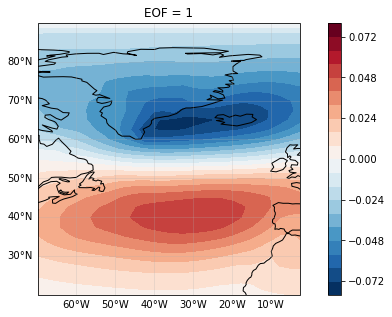

In [5]:
#plot EOFs (== v) Compute physical EOFs and plot EOF1 and 2

EOF1_phys = np.cov(Xp.T, PC1)
EOF2_phys = np.cov(Xp.T, PC2)

nlon , nlat = len(X_lonlat.longitude) ,len(X_lonlat.latitude)
v_xr = xr.DataArray(v.real.reshape(nlon , nlat , nlon * nlat),dims=["lon","lat","EOF",],coords=dict(EOF=range(1, nlon * nlat + 1), lon=X_lonlat.longitude.values , lat=X_lonlat.latitude.values),)
utils.plot_dataarray_map(v_xr.sel(EOF=1).real.T, levels =20)